# Problem Statement: Multi-Commodity Flow Problem

We are given the network as below represented as a directed graph G = (V, E)
with multiple commodities needed to be transported across the network.
Each edge e ∈ E has a capacity uₑ and a cost cₑ per unit commodity,
and each commodity k has a demand dₖ from a source sₖ to a sink tₖ.

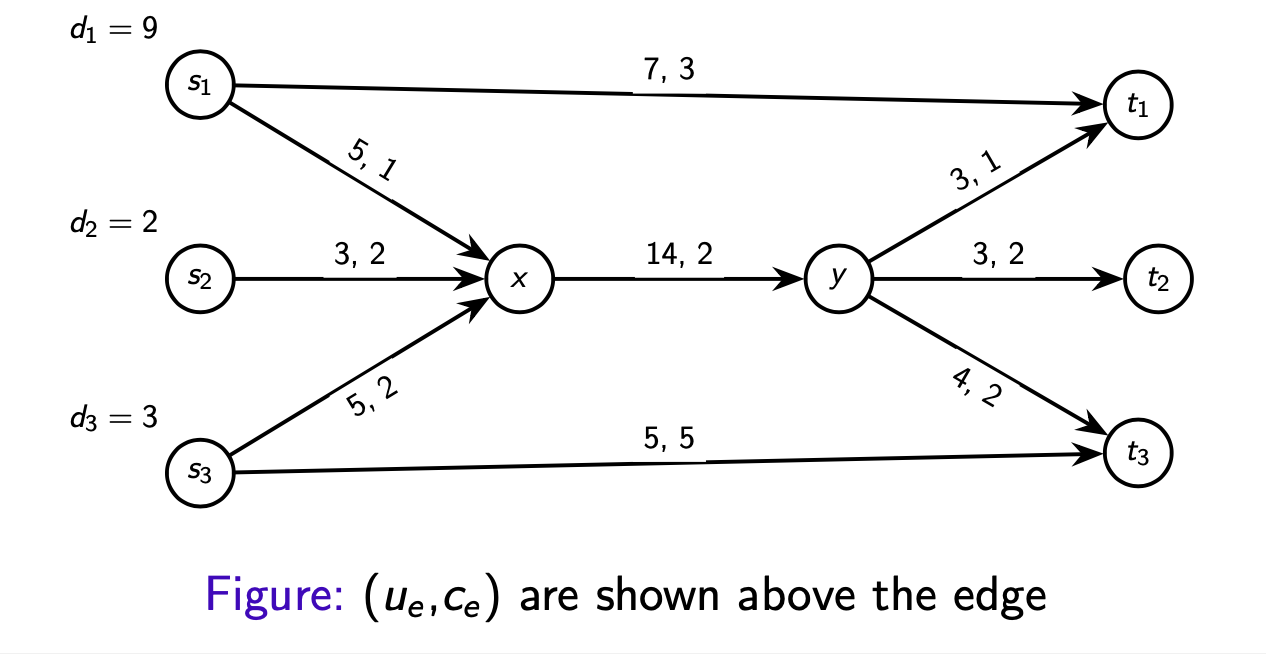






In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path
from pyomo.environ import *

import pyomo.environ as pe
import pyomo.opt as po

#### Defining Data

In [2]:
k = set(range(1, 4))

In [3]:
nodes = {'s1','s2','s3','x','y','t1','t2','t3'}

In [4]:
d = {
    ('s1',1):9,
    ('s2',2):2,
    ('s3',3):3,
    ('t1',1):-9,
    ('t2',2):-2,
    ('t3',3):-3,
}  # Demand and sink of each k (commodity)

In [5]:
directions = {
    ('s1','t1'):1,
    ('s1','x'):1,
    ('s2','x'):1,
    ('s3','x'):1,
    ('s3','t3'):1,
    ('x','y'):1,
    ('y','t1'):1,
    ('y','t2'):1,
    ('y','t3'):1,
}

In [6]:
u = {              #Capacity
    ('s1','t1'):7,
    ('s1','x'):5,
    ('s2','x'):3,
    ('s3','x'):5,
    ('s3','t3'):5,
    ('x','y'):14,
    ('y','t1'):3,
    ('y','t2'):3,
    ('y','t3'):4,
}

In [7]:
c = {               #Cost
    ('s1','t1'):3,
    ('s1','x'):1,
    ('s2','x'):2,
    ('s3','x'):2,
    ('s3','t3'):5,
    ('x','y'):2,
    ('y','t1'):1,
    ('y','t2'):2,
    ('y','t3'):2,
}

## Model


**Variables**
- Let $x_{e,k} \geq 0$ represent the flow of commodity $k$ through edge $e$

**Constraints:**
- Capacity constraints: $\sum_k x_{e,k} \leq c_e$ for all $e \in E$
- Flow conservation: For each node $v$ and each commodity $k$,
  $$\sum_{(u,v) \in E} x_{u,v,k} - \sum_{(v,w) \in E} x_{v,w,k} = 
  \begin{cases} 
      d_k, & \text{if } v = s_k \\
      -d_k, & \text{if } v = t_k \\
      0, & \text{otherwise} 
  \end{cases}$$

**Objective Function:**
- Minimize the total cost: $\min \sum_{e \in E} \sum_k c_{e} x_{e,k}$



## Implement

In [8]:
m = pe.ConcreteModel()

#### Initializing Sets

In [ ]:
m.k = pe.Set(initialize=k)
m.nodes = pe.Set(initialize=nodes)

#### Initializing Parameters

In [10]:
m.d = pe.Param(m.nodes,m.k,initialize=d,default = 0) 
m.directions = pe.Param(m.nodes,m.nodes,initialize=directions,default = 0) 
m.u = pe.Param(m.nodes,m.nodes,initialize=u, default = 0) 
m.c = pe.Param(m.nodes,m.nodes,initialize=c, default = 0)

#### Initializing Variables

In [11]:
m.X = pe.Var(m.nodes,m.nodes,m.k,domain=pe.NonNegativeReals) 

#### Defining Objective

In [12]:
obj_expr = sum( sum(m.c[i,j]*m.X[i,j,k] for k in m.k) for i in m.nodes for j in m.nodes)
m.obj = pe.Objective(sense=pe.minimize, expr=obj_expr)

#### Defining Constraints

In [13]:
# Capacity constraints
def capacity_rule(m,i,j):
    return sum(m.X[i,j,k] for k in m.k) <= m.u[i,j]

m.capacity_constraint =  pe.Constraint(m.nodes,m.nodes,rule=capacity_rule)

In [14]:
# Flow conservation
def flow_rule(m,i,k):
    return  sum(m.X[i,p,k] for p in m.nodes) - sum(m.X[w,i,k] for w in m.nodes) == m.d[i,k]

m.flow_constraint =  pe.Constraint(m.nodes,m.k,rule=flow_rule)

## Solve and Postprocess

In [15]:
solver = po.SolverFactory('gurobi')
results = solver.solve(m, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19
Read LP format model from file /var/folders/ch/190yzmt56zsfp9c_z9g_fcjc0000gn/T/tmpujupyil1.pyomo.lp
Reading time = 0.01 seconds
x1: 88 rows, 192 columns, 528 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.4.0 21E258)

CPU model: Intel(R) Core(TM) i5-5250U CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 88 rows, 192 columns and 528 nonzeros
Model fingerprint: 0x63fff851
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 88 rows and 192 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 

In [16]:
print("Minimum feasible Cost is:",pe.value(m.obj))

Minimum feasible Cost is: 56.0


In [17]:
for k in m.k:
    for i in m.nodes:
        for j in m.nodes:
            if pe.value(m.X[i,j,k])>0:
                print("Unit of Commodity",k," in direction",i,"->",j," is ",pe.value(m.X[i,j,k]))


Unit of Commodity 1  in direction y -> t1  is  2.0
Unit of Commodity 1  in direction x -> y  is  2.0
Unit of Commodity 1  in direction s1 -> x  is  2.0
Unit of Commodity 1  in direction s1 -> t1  is  7.0
Unit of Commodity 2  in direction y -> t2  is  2.0
Unit of Commodity 2  in direction x -> y  is  2.0
Unit of Commodity 2  in direction s2 -> x  is  2.0
Unit of Commodity 3  in direction s3 -> t3  is  3.0
